# Pluck a random handful of NGED feeders for all time

So we can repeat our analysis and visualisation to show the potential of NGED data as 
well.

In [1]:
import geopandas as gpd

In [2]:
jan_df = gpd.read_parquet("s3://weave.energy/smart-meter/2024-01.parquet")

In [4]:
feeders = sorted(jan_df["lv_feeder_unique_id"].dropna().drop_duplicates().sample(100))

In [5]:
all_time_df = gpd.read_parquet("s3://weave.energy/smart-meter",
                           columns=["secondary_substation_unique_id", "lv_feeder_unique_id", "aggregated_device_count_active", "total_consumption_active_import", "data_collection_log_timestamp", "geometry"],
                           filters=[("lv_feeder_unique_id", "in", feeders)])
all_time_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1561942 entries, 0 to 1561941
Data columns (total 6 columns):
 #   Column                           Non-Null Count    Dtype              
---  ------                           --------------    -----              
 0   secondary_substation_unique_id   1561942 non-null  object             
 1   lv_feeder_unique_id              1561942 non-null  object             
 2   aggregated_device_count_active   1561942 non-null  int64              
 3   total_consumption_active_import  1561942 non-null  int64              
 4   data_collection_log_timestamp    1561942 non-null  datetime64[ms, UTC]
 5   geometry                         1561942 non-null  geometry           
dtypes: datetime64[ms, UTC](1), geometry(1), int64(2), object(2)
memory usage: 71.5+ MB


In [6]:
all_time_df.sort_values(["data_collection_log_timestamp", "lv_feeder_unique_id"], inplace=True)
all_time_df["latitude"] = all_time_df["geometry"].y
all_time_df["longitude"] = all_time_df["geometry"].x
all_time_df["total_consumption_active_import"] /= 1000
all_time_df.to_csv("nged-100-feeders.csv", index=False, columns=["data_collection_log_timestamp", "secondary_substation_unique_id", "lv_feeder_unique_id", "latitude", "longitude", "aggregated_device_count_active", "total_consumption_active_import"])

In [7]:
all_time_df[all_time_df["data_collection_log_timestamp"] == "2024-10-15 12:00:00Z"].explore()

/Users/steve/Code/weave/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: title={'center': 'Daily kWh consumption per low-voltage feeder'}, xlabel='Date', ylabel='Consumption (kWh)'>

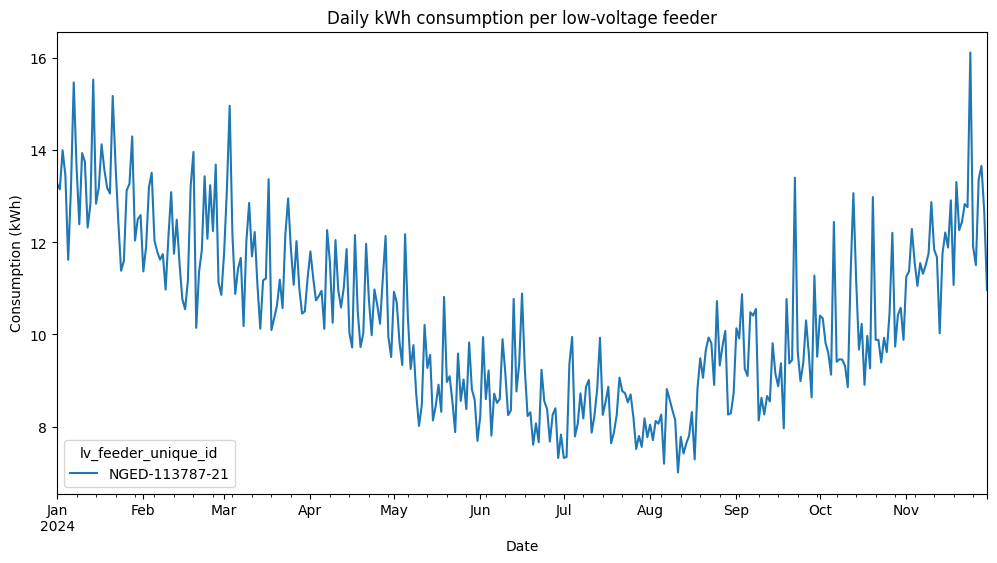

In [13]:
feeder_df = all_time_df[all_time_df["lv_feeder_unique_id"] =="NGED-113787-21"]
feeder_df["normalised_consumption"] = feeder_df["total_consumption_active_import"] / feeder_df["aggregated_device_count_active"]
timeseries = feeder_df.pivot(index="data_collection_log_timestamp", columns="lv_feeder_unique_id", values="normalised_consumption")
timeseries.resample("d").sum().plot(figsize=(12,6), xlabel="Date", ylabel="Consumption (kWh)", title="Daily kWh consumption per low-voltage feeder")

In [32]:
smaller_subset = sorted(all_time_df["lv_feeder_unique_id"].dropna().drop_duplicates().sample(75))
smaller_df = all_time_df[all_time_df["lv_feeder_unique_id"].isin(smaller_subset)]
smaller_df.to_csv("nged-75-feeders.csv", index=False, columns=["data_collection_log_timestamp", "secondary_substation_unique_id", "lv_feeder_unique_id", "latitude", "longitude", "aggregated_device_count_active", "total_consumption_active_import"])